In [58]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [59]:
from fastai.tabular.all import *
from wwf.tab.export import *
from bnbsl import *

from classes import *
from utils import *

In [60]:
SEASON = '21'
set_seed(int(SEASON))

## Download HKJC odds

In [61]:
path_raw = Path('raw_data')
path_data = Path('data')

path_output = Path('output')

In [62]:
session = requests.Session()
r = session.get('http://bet.hkjc.com')
cookies = r.cookies

In [63]:
odds_url = 'https://bet.hkjc.com/football/getJSON.aspx?jsontype=odds_chl.aspx'
response = session.post(
    odds_url,
    headers={'referer':'http://bet.hkjc.com'},
    cookies=cookies
)

In [64]:
with open(path_data/'json'/f'odds_chl-{datetime.now().strftime("%Y-%m-%d-%H-%M-%S")}.txt', 'w') as f:
    f.write(response.text)

In [65]:
matches_json = json.loads(response.text)[1]['matches']

In [66]:
# Example
# matches_json = json.loads(open(path_data/'json'/'odds_chl-2021-11-20-20-15-14.txt').read())[1]['matches']

In [67]:
matches = [Match(m) for m in matches_json if m['matchStatus'] == 'Defined']
odds = [m.export() for m in matches]

['20220304FRI7', '2022-Mar-05', '01:30:00', 'German Division 2 [GD2]', 'Holstein Kiel', 'Paderborn', 'true', '10.5', '2.00', '1.72', 'false', '13.5', '3.90', '1.20', 'false', '11.5', '2.50', '1.46']
['20220304FRI8', '2022-Mar-05', '01:30:00', 'German Division 2 [GD2]', 'Darmstadt', 'Heidenheim', 'false', '13.5', '4.05', '1.19', 'false', '11.5', '2.55', '1.45', 'true', '10.5', '2.02', '1.70']
['20220304FRI19', '2022-Mar-05', '03:30:00', 'German Division 1 [GSL]', 'Bielefeld', 'Augsburg', 'false', '10.5', '2.25', '1.57', 'false', '13.5', '4.55', '1.15', 'true', '9.5', '1.80', '1.90']
['20220304FRI20', '2022-Mar-05', '03:45:00', 'Italian Division 1 [ISA]', 'Inter Milan', 'Salernitana', 'false', '14.5', '5.80', '1.09', 'false', '11.5', '2.65', '1.42', 'true', '10.5', '2.05', '1.68']
['20220304FRI24', '2022-Mar-05', '04:00:00', 'Spanish Division 1 [SFL]', 'Alaves', 'Sevilla', 'false', '9.5', '2.30', '1.54', 'false', '12.5', '5.30', '1.11', 'true', '8.5', '1.80', '1.90']
['20220304FRI25', '2

In [68]:
cols_match = ['MatchDay', 'Date', 'Time', 'LeagueJC', 'HomeTeamJC', 'AwayTeamJC']
cols_odds0 = ['MAINLINE_0', 'CHL_LINE_0', 'CHL_H_0', 'CHL_L_0']
cols_odds1 = ['MAINLINE_1', 'CHL_LINE_1', 'CHL_H_1', 'CHL_L_1']
cols_odds2 = ['MAINLINE_2', 'CHL_LINE_2', 'CHL_H_2', 'CHL_L_2']
cols_odds  = ['MAINLINE', 'CHL_LINE', 'CHL_H', 'CHL_L']
cols_pred  = ['alpha_1', 'alpha_2', 'mu_1', 'mu_2', 'omega', 'corr']

cols = cols_match + cols_odds0 + cols_odds1 + cols_odds2

In [69]:
odds = pd.DataFrame(odds, columns=cols)
odds = odds.fillna(value=np.nan)

In [70]:
cols_odds_ = cols_odds0[1:]+cols_odds1[1:]+cols_odds2[1:]
odds[cols_odds_] = odds[cols_odds_].astype(float)

In [71]:
odds['MatchDay'] = odds['MatchDay'].str[8:]
odds['Date'] = pd.to_datetime(odds['Date'])
odds['Time'] = pd.to_datetime(odds['Time'], format='%H:%M:%S').dt.time

In [72]:
odds['DateTimeJC'] = pd.to_datetime(odds['Date'].dt.date.map(str) + '-' + odds['Time'].map(str))
odds['DateTimeJC'] = odds['DateTimeJC'].dt.tz_localize('Hongkong')
odds['DateTime'] = odds['DateTimeJC'].dt.tz_convert('GB')

In [73]:
map_league = pd.read_csv(path_data/'league.csv')
map_team = pd.read_csv(path_data/'team.csv')

In [74]:
div = ['E0', 'E1', 'E2', 'D1', 'D2', 'SP1', 'SP2', 'I1', 'I2', 'F1', 'F2']
map_league = map_league[map_league.Div.isin(div)].reset_index(drop=True)

In [75]:
# Map Div name
odds = odds.merge(map_league[['LeagueJC', 'Div']], 'inner', on='LeagueJC')

In [76]:
# Map Team name
odds = odds.merge(map_team[['TeamNameJC', 'TeamName']].rename(columns={'TeamName':'HomeTeam'}), 'inner', 
                  left_on='HomeTeamJC', right_on='TeamNameJC').drop(columns=['TeamNameJC'])
odds = odds.merge(map_team[['TeamNameJC', 'TeamName']].rename(columns={'TeamName':'AwayTeam'}), 'inner', 
                  left_on='AwayTeamJC', right_on='TeamNameJC').drop(columns=['TeamNameJC'])

## Download recent stats

In [77]:
# Download latest results in current season
!wget -q https://www.football-data.co.uk/mmz4281/{SEASON}{int(SEASON)+1}/data.zip -O raw_data/data.zip

# Unzip to folder
!unzip -q -o raw_data/data.zip -d raw_data/{SEASON}

In [78]:
usecols = ['Div', 'Date', 'HomeTeam', 'AwayTeam', 'HC', 'AC', 'FTHG', 'FTAG', 'HS', 'AS', 'HST', 'AST']
dtype = {'HC':'float', 'AC':'float'}
parse_dates = ['Date']

seasons = [SEASON]

dfs = []

for folder in sorted(path_raw.iterdir()):
    if folder.is_dir() and folder.name in seasons: 
        for file in sorted(folder.glob('*.csv')):
            try:
                df = pd.read_csv(file, usecols=usecols, dtype=dtype, parse_dates=parse_dates, dayfirst=True)
                df['Season'] = folder.name
                dfs.append(df)
            except:
                continue

In [79]:
df_season = pd.concat(dfs)
df_season = df_season.dropna()
df_season = df_season.sort_values(['Div', 'Date', 'HomeTeam']).reset_index(drop=True)

In [80]:
df_hist = pd.read_csv(path_data/'data.csv', dtype={'HC':'float', 'AC':'float'}, parse_dates=['Date'])
df_hist = df_hist.query(f'Season == {int(SEASON)-1}').reset_index(drop=True)

In [81]:
df_season = pd.concat([df_hist[df_season.columns], df_season])

In [82]:
# Make features on historical stats (Home and Away)
stats = ['FTHG', 'HS', 'HST', 'HC', 'FTAG', 'AS', 'AST', 'AC']
df_home, df_away = joinLastGamesStatsHomeAway(df_season, stats)

In [83]:
# Make features on historical stats (For and Against)
stats = [('FTHG', 'FTAG', 'FTG'), ('HS', 'AS', 'S'), ('HST', 'AST', 'ST'), ('HC', 'AC', 'C')]
df_for, df_against = joinLastGamesStatsForAgainst(df_season, stats)

In [84]:
df_home = df_home.sort_values(['HomeTeam', 'Date']).reset_index(drop=True)
df_away = df_away.sort_values(['AwayTeam', 'Date']).reset_index(drop=True)

df_home = df_home.groupby('HomeTeam')[df_home.columns[df_home.columns.str.contains('Avg')]].last().reset_index()
df_away = df_away.groupby('AwayTeam')[df_away.columns[df_away.columns.str.contains('Avg')]].last().reset_index()

In [85]:
odds = odds.merge(df_home, 'left', 'HomeTeam').merge(df_away, 'left', 'AwayTeam')

In [86]:
cols_home = df_for.columns[df_for.columns.str.contains('Avg')]
cols_home = dict(zip(cols_home, 'Home'+cols_home))
cols_home.update({'Team':'HomeTeam'})

cols_away = df_for.columns[df_for.columns.str.contains('Avg')]
cols_away = dict(zip(cols_home, 'Away'+cols_away))
cols_away.update({'Team':'AwayTeam'})

df_for = df_for.groupby('Team')[df_for.columns[df_for.columns.str.contains('Avg')]].last().reset_index()
odds = odds.merge(df_for.rename(columns=cols_home), 'left', 'HomeTeam').merge(df_for.rename(columns=cols_away), 'left', 'AwayTeam')

In [87]:
cols_home = df_against.columns[df_against.columns.str.contains('Avg')]
cols_home = dict(zip(cols_home, 'Home'+cols_home))
cols_home.update({'Team':'HomeTeam'})

cols_away = df_against.columns[df_against.columns.str.contains('Avg')]
cols_away = dict(zip(cols_home, 'Away'+cols_away))
cols_away.update({'Team':'AwayTeam'})

df_against = df_against.groupby('Team')[df_against.columns[df_against.columns.str.contains('Avg')]].last().reset_index()
odds = odds.merge(df_against.rename(columns=cols_home), 'left', 'HomeTeam').merge(df_against.rename(columns=cols_away), 'left', 'AwayTeam')

In [88]:
add_datepart(odds, 'DateTime', prefix='', drop=False);

In [89]:
display_df(odds.head(5).T)

,0,1,2,3,4
MatchDay,FRI7,FRI8,SAT16,SAT17,SAT18
Date,2022-03-05 00:00:00,2022-03-05 00:00:00,2022-03-05 00:00:00,2022-03-05 00:00:00,2022-03-05 00:00:00
Time,01:30:00,01:30:00,20:30:00,20:30:00,20:30:00
LeagueJC,German Division 2 [GD2],German Division 2 [GD2],German Division 2 [GD2],German Division 2 [GD2],German Division 2 [GD2]
HomeTeamJC,Holstein Kiel,Darmstadt,Sandhausen,Schalke 04,St. Pauli
AwayTeamJC,Paderborn,Heidenheim,Hannover,Rostock,Karlsruher
MAINLINE_0,true,false,false,true,false
CHL_LINE_0,10.5,13.5,13.5,9.5,13.5
CHL_H_0,2.0,4.05,4.55,1.73,4.55
CHL_L_0,1.72,1.19,1.15,1.98,1.15


## Load model

In [90]:
learn_bnb = load_learner('models/learn_bnbsl.pkl')

In [91]:
to = load_pandas('models/to.pkl')

In [92]:
def predict(self, row):
    "Predict on a Pandas Series"
    dl = self.dls.test_dl(row.to_frame().T)
    dl.dataset.conts = dl.dataset.conts.astype(np.float32)
    inp,preds,_ = self.get_preds(dl=dl, with_input=True, with_decoded=False)
    b = tuplify(inp)
    full_dec = self.dls.decode(b)
    return full_dec,preds[0]

learn_bnb.predict = MethodType(predict, learn_bnb)

In [93]:
to_tst = to.new(odds)
to_tst.process()
# to_tst.items.head()

In [94]:
tst_dl = learn_bnb.dls.valid.new(to_tst)
tst_dl.show(max_n=999)

,Div,HomeTeam,AwayTeam,HSLast5Avg,HCLast5Avg,ASLast5Avg,ACLast5Avg,HomeSForLast5Avg,AwaySForLast5Avg,HomeSAgainstLast5Avg,AwaySAgainstLast5Avg
0,D2,Holstein Kiel,Paderborn,17.2,5.0,12.8,3.4,11.2,15.6,15.4,13.4
1,D2,Darmstadt,Heidenheim,17.0,6.4,14.2,5.6,22.2,9.8,11.6,11.6
2,D2,Sandhausen,Hannover,12.0,3.6,9.8,3.4,10.0,12.4,11.8,12.2
3,D2,Schalke 04,Hansa Rostock,20.4,7.0,14.8,5.0,15.2,13.6,13.0,10.8
4,D2,St Pauli,Karlsruhe,14.4,5.8,12.2,4.2,11.0,14.8,15.0,16.8
5,D2,Nurnberg,Hamburg,14.6,5.0,14.6,5.4,15.8,12.6,18.8,11.8
6,D2,Erzgebirge Aue,Regensburg,13.0,2.2,12.2,7.2,8.6,17.2,15.4,13.2
7,D2,Fortuna Dusseldorf,Ingolstadt,15.4,8.0,13.4,3.0,14.8,12.6,11.4,18.4
8,D2,Werder Bremen,Dresden,16.4,6.0,10.4,4.8,18.4,11.0,11.6,14.6
9,D1,Bielefeld,Augsburg,12.8,5.4,13.8,4.8,10.0,14.4,16.2,15.8


In [95]:
pred, _ = learn_bnb.get_preds(dl=tst_dl)

In [96]:
alpha = F.softplus(pred[:, 0:2])
mu = F.softplus(pred[:, 2:4])
omega = pred[:, 4]

total_count = 1. / alpha
logits = torch.log(alpha * mu)

# print(alpha, mu, omega)

In [97]:
# Method 1:
corr = omega * torch.sqrt(mu.prod(-1)) * alpha.prod(-1) / ((1.+alpha)**(1./alpha+1.)).prod(-1) / torch.sqrt((1.+alpha*mu).prod(-1))

In [98]:
# Method 2:
# d = 1.-math.exp(-1)
# corr = omega * d**2 * torch.sqrt(mu.prod(-1)*(1.+alpha*mu).prod(-1)) * ((1.+d*alpha*mu)**(-1-1/alpha)).prod(-1)

In [99]:
odds[cols_pred] = torch.cat([alpha, mu, omega.unsqueeze(-1), corr.unsqueeze(-1)], dim=-1)

In [100]:
odds0 = odds[cols_match+cols_odds0+cols_pred].rename(columns=dict(zip(cols_odds0, cols_odds)))
odds1 = odds[cols_match+cols_odds1+cols_pred].rename(columns=dict(zip(cols_odds1, cols_odds)))
odds2 = odds[cols_match+cols_odds2+cols_pred].rename(columns=dict(zip(cols_odds2, cols_odds)))

In [101]:
odds = pd.concat([odds0, odds1, odds2]).dropna().reset_index(drop=True)
odds['MAINLINE'] = np.where(odds['MAINLINE']=='true', True, False)

In [102]:
odds.head(5)

,MatchDay,Date,Time,LeagueJC,HomeTeamJC,AwayTeamJC,MAINLINE,CHL_LINE,CHL_H,CHL_L,alpha_1,alpha_2,mu_1,mu_2,omega,corr
0,FRI7,2022-03-05,01:30:00,German Division 2 [GD2],Holstein Kiel,Paderborn,True,10.5,2.00,1.72,0.038276,0.032721,5.232889,5.937193,-52.664101,-0.040125
1,FRI8,2022-03-05,01:30:00,German Division 2 [GD2],Darmstadt,Heidenheim,False,13.5,4.05,1.19,0.058230,0.081851,5.351035,4.427569,-44.263397,-0.097086
2,SAT16,2022-03-05,20:30:00,German Division 2 [GD2],Sandhausen,Hannover,False,13.5,4.55,1.15,0.079193,0.078747,4.777541,5.192954,-46.532166,-0.129970
3,SAT17,2022-03-05,20:30:00,German Division 2 [GD2],Schalke 04,Rostock,True,9.5,1.73,1.98,0.056521,0.100358,5.486784,3.410827,-38.891121,-0.090238
4,SAT18,2022-03-05,20:30:00,German Division 2 [GD2],St. Pauli,Karlsruher,False,13.5,4.55,1.15,0.059524,0.076593,5.510159,4.899028,-47.046658,-0.104419


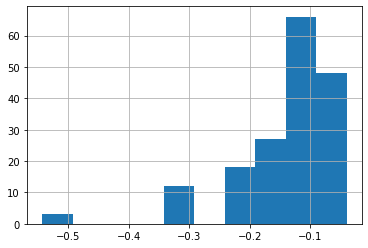

In [103]:
odds['corr'].hist();

In [104]:
prob_hilo = []

for r in list(zip(odds['alpha_1'], odds['alpha_2'], odds['mu_1'], odds['mu_2'], odds['omega'], odds['CHL_LINE'])):
    total_count = 1. / torch.tensor(r[0:2], device='cpu') 
    logits = torch.log(torch.tensor(r[0:2], device='cpu') * torch.tensor(r[2:4], device='cpu'))
    omega = torch.tensor(r[4], device='cpu')

    bnb_corner = BivariateNegativeBinomialSL(total_count=total_count, omega=omega, logits=logits)
    value = torch.cartesian_prod(torch.arange(0., 15.), torch.arange(0., 15.))
    corner = bnb_corner.log_prob(value).exp()
    
    line = r[5]
    mask = value.sum(-1) < line
    prob_lo = corner[mask].sum()
    prob_hi = 1 - prob_lo
    
    prob_hilo.append([prob_hi.item(), prob_lo.item()])

In [105]:
odds[['prob_hi', 'prob_lo']] = prob_hilo

In [106]:
odds['kelly_hi'] = (odds['prob_hi'] * odds['CHL_H'] - 1) / (odds['CHL_H'] - 1)
odds['kelly_lo'] = (odds['prob_lo'] * odds['CHL_L'] - 1) / (odds['CHL_L'] - 1)

In [107]:
odds['kelly'] = np.where(
    np.maximum(odds['kelly_hi'], odds['kelly_lo']) > 0, 
    np.where(odds['kelly_hi'] > odds['kelly_lo'], odds['kelly_hi'], odds['kelly_lo']), 
    np.nan
)

In [108]:
odds['bet'] = np.where(
    np.maximum(odds['kelly_hi'], odds['kelly_lo']) > 0, 
    np.where(odds['kelly_hi'] > odds['kelly_lo'], 'High', 'Low'), 
    None
)

In [109]:
odds = odds.sort_values('kelly', ascending=False).reset_index(drop=True)

In [110]:
odds['selected'] = np.where(
    odds['MAINLINE']==True, np.where(
        odds['kelly']>0.3, '$$$', np.where(
            odds['kelly']>0.2, '$$', np.where(
                odds['kelly']>0.1, '$', None))), 
    None
)

In [111]:
odds = odds.drop(columns=cols_pred+['kelly_hi', 'kelly_lo'])

In [112]:
odds[odds.bet.notna() & odds.selected.notna()]

,MatchDay,Date,Time,LeagueJC,HomeTeamJC,AwayTeamJC,MAINLINE,CHL_LINE,CHL_H,CHL_L,prob_hi,prob_lo,kelly,bet,selected
5,SAT64,2022-03-05,23:15:00,Spanish Division 1 [SFL],Espanyol,Getafe,True,9.5,2.05,1.68,0.274836,0.725164,0.320995,Low,$$$
8,SUN44,2022-03-06,22:00:00,French Division 1 [FFL],Reims,Strasbourg,True,10.5,2.10,1.65,0.284153,0.715847,0.278688,Low,$$
11,SUN38,2022-03-06,22:00:00,Eng Premier [EPL],Watford,Arsenal,True,10.5,2.15,1.62,0.289839,0.710161,0.242679,Low,$$
15,SUN52,2022-03-06,23:15:00,Spanish Division 1 [SFL],CF Elche,Barcelona,True,9.5,2.19,1.60,0.291924,0.708076,0.221537,Low,$$
18,SAT33,2022-03-05,23:00:00,Eng Premier [EPL],Wolves,Crystal Palace,True,10.5,2.15,1.62,0.306258,0.693742,0.199778,Low,$
20,SAT17,2022-03-05,20:30:00,German Division 2 [GD2],Schalke 04,Rostock,True,9.5,1.73,1.98,0.399530,0.600470,0.192786,Low,$
24,FRI25,2022-03-05,04:00:00,French Division 1 [FFL],Lorient,Lyon,True,9.5,1.93,1.77,0.360484,0.639516,0.171356,Low,$
26,SAT19,2022-03-05,21:00:00,Spanish Division 1 [SFL],Osasuna,Villarreal,True,9.5,2.19,1.60,0.311498,0.688502,0.169339,Low,$
33,SAT68,2022-03-06,00:00:00,French Division 1 [FFL],Lens,Brest,True,9.5,2.05,1.68,0.353995,0.646005,0.125423,Low,$
34,SUN59,2022-03-07,00:05:00,French Division 1 [FFL],Lille,Clermont,True,9.5,1.98,1.73,0.369488,0.630512,0.124365,Low,$


In [113]:
display_df(odds[odds.MatchDay.isin(odds[odds.bet.notna() & odds.selected.notna()].MatchDay) & odds.bet.notna()])

,MatchDay,Date,Time,LeagueJC,HomeTeamJC,AwayTeamJC,MAINLINE,CHL_LINE,CHL_H,CHL_L,prob_hi,prob_lo,kelly,bet,selected
0,SAT64,2022-03-05,23:15:00,Spanish Division 1 [SFL],Espanyol,Getafe,False,12.5,4.55,1.15,0.072430,0.927570,0.444701,Low,None
1,SUN44,2022-03-06,22:00:00,French Division 1 [FFL],Reims,Strasbourg,False,13.5,4.40,1.16,0.084593,0.915407,0.386699,Low,None
2,SAT64,2022-03-05,23:15:00,Spanish Division 1 [SFL],Espanyol,Getafe,False,10.5,2.65,1.42,0.185270,0.814730,0.373609,Low,None
3,SUN38,2022-03-06,22:00:00,Eng Premier [EPL],Watford,Arsenal,False,13.5,4.55,1.15,0.086184,0.913816,0.339255,Low,None
4,SAT17,2022-03-05,20:30:00,German Division 2 [GD2],Schalke 04,Rostock,False,13.5,4.55,1.15,0.087961,0.912039,0.325631,Low,None
5,SAT64,2022-03-05,23:15:00,Spanish Division 1 [SFL],Espanyol,Getafe,True,9.5,2.05,1.68,0.274836,0.725164,0.320995,Low,$$$
6,SUN44,2022-03-06,22:00:00,French Division 1 [FFL],Reims,Strasbourg,False,11.5,2.70,1.40,0.198273,0.801727,0.306044,Low,None
7,SUN52,2022-03-06,23:15:00,Spanish Division 1 [SFL],CF Elche,Barcelona,False,12.5,5.10,1.12,0.075319,0.924681,0.297026,Low,None
8,SUN44,2022-03-06,22:00:00,French Division 1 [FFL],Reims,Strasbourg,True,10.5,2.10,1.65,0.284153,0.715847,0.278688,Low,$$
9,SAT33,2022-03-05,23:00:00,Eng Premier [EPL],Wolves,Crystal Palace,False,13.5,4.55,1.15,0.094714,0.905286,0.273861,Low,None


In [114]:
odds.to_csv(path_output/f'odds-{datetime.now().strftime("%Y-%m-%d")}.csv', float_format='%.2f', index=False)